In [ ]:
import math
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from challenge.src.common import load_data, prepare_train_data, generate_submission
from challenge.src.eval import evaluate_retrieval, visualize_retrieval
# ==== Config ====
MODEL_PATH = "models/maxmatch_adapter_k6_sinkhorn.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 256




LR = 0.0017
WEIGHT_DECAY = 2.0e-5

K_SLOTS = 6
SLOT_DROPOUT_P = 0.15

SINKHORN_ITERS = 11
SINKHORN_TAU_START = 0.208
SINKHORN_TAU_END   = 0.190
DETACH_ASSIGNMENT = True

SCALE_S = 0.47
DELTA_1 = 0.38
DELTA_2 = 0.61
DELTA_3 = 0.564

LAMBDA_ISDL = 0.110
LAMBDA_GDL  = 0.085
LAMBDA_MMD  = 0.015
LAMBDA_DIV  = 0.019





# ============================================================
# 1) Head set-based: t(1024) -> S_T (K x 1536)
# ============================================================
class SetPredictionHead(nn.Module):
    """
    Converte un embedding testuale globale in K slot nello spazio visivo (1536).
    - K query vettori learnable (inizializzati nel target space).
    - Proiezione testo -> spazio visivo + gating per diversificare contributi.
    - Piccolo dropout per evitare collasso precoce.
    """
    def __init__(self, d_text=1024, d_vis=1536, K=4, hidden=2048, slot_dropout_p=0.1):
        super().__init__()
        self.K = K
        self.d_vis = d_vis

        self.text_to_vis = nn.Sequential(
            nn.Linear(d_text, hidden),
            nn.GELU(),
            nn.Linear(hidden, d_vis),
        )

        self.slot_queries = nn.Parameter(torch.randn(K, d_vis) * 0.02)
        self.gate_per_slot = nn.Linear(d_text, K)
        self.delta_per_slot = nn.Linear(d_text, K * d_vis)

        self.ln_slots = nn.LayerNorm(d_vis)
        self.ln_text  = nn.LayerNorm(d_vis)
        self.dropout = nn.Dropout(p=slot_dropout_p)

    def forward(self, t: torch.Tensor):
        B = t.size(0)
        t_vis = self.text_to_vis(t)                 # (B, d_vis)
        t_vis = self.ln_text(t_vis)

        gate  = torch.sigmoid(self.gate_per_slot(t))      # (B, K)
        delta = self.delta_per_slot(t).view(B, self.K, self.d_vis)

        Q = self.slot_queries.unsqueeze(0).expand(B, -1, -1)  # (B, K, d_vis)
        t_vis_exp = t_vis.unsqueeze(1).expand(-1, self.K, -1)
        gate_exp  = gate.unsqueeze(-1)

        # --- residui (pre-fusione globale) ---
        R = Q + gate_exp * t_vis_exp + delta               # (B, K, d_vis)
        R = self.ln_slots(R)
        R = self.dropout(R)
        E_T = F.normalize(R, dim=-1)                       # residui normalizzati (per ISDL)

        # --- fusione globale per scoring ---
        S_T = E_T + F.normalize(t_vis, dim=-1).unsqueeze(1)
        S_T = F.normalize(S_T, dim=-1)
        return S_T, E_T, F.normalize(t_vis, dim=-1)
# ============================================================
# 2) Sinkhorn matching (soft, entropic-regularized doubly-stochastic)
#    sim -> P ~ doubly-stochastic, poi S_H = <P, sim>/K
# ============================================================
def sinkhorn_logspace(log_K: torch.Tensor, iters: int = 10) -> torch.Tensor:
    """
    Log-space Sinkhorn per stabilità numerica.
    log_K: (B, K, K) log-kernel (logits pre-softmax)
    Ritorna log_P: (B, K, K) ~ log matrix bistocastica
    """
    B, K, _ = log_K.shape
    log_u = torch.zeros(B, K, device=log_K.device)
    log_v = torch.zeros(B, K, device=log_K.device)

    for _ in range(iters):
        # normalizza righe
        log_u = -torch.logsumexp(log_K + log_v.unsqueeze(1), dim=2)
        # normalizza colonne
        log_v = -torch.logsumexp(log_K + log_u.unsqueeze(2), dim=1)

    log_P = log_K + log_u.unsqueeze(2) + log_v.unsqueeze(1)
    return log_P

def sinkhorn_assignment(sim: torch.Tensor, tau: float = 0.1, iters: int = 10,
                        detach_input: bool = True) -> torch.Tensor:
    """
    sim: (B, K, K) similarità coseno.
    Costruisce kernel K_ij = exp(sim_ij / tau), applica Sinkhorn per ottenere P ~ bistocastica.
    Se detach_input=True, rimuove il gradiente dalla matrice di sim nel calcolo dell'assegnamento,
    replicando lo schema "stop-grad" usato in MaxMatch per la parte di matching.
    """
    if detach_input:
        sim = sim.detach()
    log_K = sim / max(tau, 1e-6)
    log_P = sinkhorn_logspace(log_K, iters=iters)
    P = torch.exp(log_P)  # (B, K, K), righe/colonne ~ 1
    return P

def cosine_matrix(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    # (B, K, D) x (B, D, K) -> (B, K, K)
    return torch.matmul(A, B.transpose(-1, -2))

def s_h_maxmatch_sinkhorn(
    S_T: torch.Tensor, V: torch.Tensor, *,
    tau: float, iters: int, detach: bool
) -> torch.Tensor:
    B, K, D = S_T.shape
    Vn = F.normalize(V, dim=-1)
    S_V = Vn.unsqueeze(1).expand(-1, K, -1)        # (B, K, D)
    sims = torch.matmul(S_T, S_V.transpose(-1, -2))# (B, K, K)
    P = sinkhorn_assignment(sims, tau=tau, iters=iters, detach_input=detach)
    return (P * sims).sum(dim=(1, 2)) / K
    
USE_DEGENERATE_SH = True  # True: rapido e identico nel caso colonne uguali

def s_h_singleton_target(S_T: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
    # S_T: (B,K,D), V: (B,D)
    Vn = F.normalize(V, dim=-1)
    sims = torch.einsum('bkd,bd->bk', S_T, Vn)  # (B,K)
    return sims.mean(dim=1)                      # (B,)

def s_h(S_T: torch.Tensor, V: torch.Tensor, *, tau, iters, detach) -> torch.Tensor:
    if USE_DEGENERATE_SH:
        return s_h_singleton_target(S_T, V)
    else:
        return s_h_maxmatch_sinkhorn(S_T, V, tau=tau, iters=iters, detach=detach)



def triplet_maxmatch_sh(S_T, V, delta1, *, tau, iters, detach):
    B, K, D = S_T.shape
    s_pos = s_h_maxmatch_sinkhorn(S_T, V, tau=tau, iters=iters, detach=detach)  # (B,)
    V_all = F.normalize(V, dim=-1)

    max_negs = []
    CH = 64  # blocco sicuro; puoi alzare/abbassare in base alla GPU
    for start in range(0, B, CH):
        end = min(B, start + CH)
        S_blk = S_T[start:end]                                   # (ch,K,D)

        # confronta ogni S_blk[i] con tutte le immagini del batch (B)
        S_exp = S_blk.unsqueeze(1).expand(end - start, B, K, D).reshape((end - start) * B, K, D)
        V_exp = V_all.unsqueeze(0).expand(end - start, B, D).reshape((end - start) * B, D)

        s_blk = s_h(S_exp, V_exp, tau=tau, iters=iters, detach=detach)

        s_blk = s_blk.view(end - start, B)                       # (ch, B)

        # maschera SOLO il positivo per riga: colonna (start + r)
        rows = torch.arange(end - start, device=S_T.device)
        cols = torch.arange(start, end, device=S_T.device)
        s_blk[rows, cols] = float('-inf')

        max_negs.append(s_blk.max(dim=1).values)                 # (ch,)

    s_neg = torch.cat(max_negs, dim=0)                           # (B,)
    return F.relu(delta1 + s_neg - s_pos).mean()

# ============================================================
# 3) ISDL – Intra-Set Diversity Loss (Alomari 2025)
#     Minimizza similarità intra-slot (promuove diversità)
# ============================================================
def isdl_intra_set_diversity_exp(S_T: torch.Tensor, s: float, delta3: float) -> torch.Tensor:
    B, K, D = S_T.shape
    C = torch.matmul(S_T, S_T.transpose(-1, -2)).clamp(-1, 1)  # (B,K,K)
    mask = ~torch.eye(K, device=S_T.device, dtype=torch.bool).unsqueeze(0).expand(B, K, K)
    C_off = C[mask]  # (B*K*(K-1),)
    loss = torch.exp(s * (C_off - delta3)).mean()
    return loss


# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]
# ============================================================
# 4) GDL – Global Discriminative Loss (Alomari 2025)
#     Rafforza separazione vs negativi di batch (ranking)
# ============================================================
def gdl_global_discriminative_true(S_T, t_vis_norm, s: float, delta2: float):
    """
    GDL: penalizza allineamento slot ↔ globale (stessa modalità/spazio),
    spingendo gli slot a non collassare sul globale.
    """
    # sim per-slot col globale: (B,K)
    sims = torch.einsum('bkd,bd->bk', S_T, t_vis_norm).clamp(-1,1)
    return torch.exp(s * (sims - delta2)).mean()



# ============================================================
# 5) Diagnostica: log-varianza intra-slot
# ============================================================
@torch.no_grad()
def slot_log_variance(S_T: torch.Tensor) -> float:
    var_fd = S_T.var(dim=1, unbiased=False)   # (B, D)
    var_mean = var_fd.mean(dim=1).mean().clamp_min(1e-8)
    return float(torch.log(var_mean).item())


@torch.no_grad()
def mean_offdiag_cos(E_Tn):
    K = E_Tn.size(1)
    C = torch.matmul(E_Tn, E_Tn.transpose(-1,-2))          # (B,K,K)
    off = C - torch.eye(K, device=E_Tn.device).unsqueeze(0)
    denom = max(K*(K-1), 1)
    return float(off.abs().sum(dim=(1,2)).mean().item() / denom)

def gaussian_kernel(x, y, sigma=1.0):
    x2 = (x*x).sum(dim=1, keepdim=True)
    y2 = (y*y).sum(dim=1, keepdim=True)
    xy = x @ y.t()
    dist = x2 - 2*xy + y2.t()
    return torch.exp(-dist / (2*sigma**2))

def mmd_rbf(x, y, sigma=1.0):
    Kxx = gaussian_kernel(x, x, sigma).mean()
    Kyy = gaussian_kernel(y, y, sigma).mean()
    Kxy = gaussian_kernel(x, y, sigma).mean()
    return Kxx + Kyy - 2*Kxy

def diversity_regularizer_exp(E: torch.Tensor, s: float = 1.0):
    """
    Accetta:
      - E: (B,K,D)  -> viene flattenato a (B*K, D)
      - E: (N,D)    -> usato così com'è
    """
    if E.dim() == 3:
        B, K, D = E.shape
        E = E.reshape(B * K, D)
    elif E.dim() == 2:
        D = E.size(1)
    else:
        raise ValueError(f"diversity_regularizer_exp: atteso 2D/3D, trovato {tuple(E.shape)}")

    C = (E @ E.t()).clamp(-1, 1)  # (N,N)
    mask = ~torch.eye(E.size(0), device=E.device, dtype=torch.bool)
    C_off = C[mask]
    return torch.exp(-2.0 * (1 - C_off)).mean()


def subsample_rows(X: torch.Tensor, max_n: int):
    n = X.size(0)
    if n <= max_n: return X
    idx = torch.randint(0, n, (max_n,), device=X.device)
    return X.index_select(0, idx)

# Subsample per evitare O(n^2) pieno
AGG_MAX = 256      # righe per MMD
RES_MAX = 512      # righe per DIV (BK ~ B*K)
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int,
                lr: float,
                logvar_warm_epochs: int = 3) -> nn.Module:

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-5)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
    best_val = -1e9

    for epoch in range(1, epochs + 1):
        model.train()
        train_s_h_sum, train_batches = 0.0, 0
        logvar_vals, offdiag_vals = [], []
        frac = (epoch - 1) / max(epochs - 1, 1)
        SINKHORN_TAU = SINKHORN_TAU_START + frac * (SINKHORN_TAU_END - SINKHORN_TAU_START)
        if epoch >= int(0.5 * epochs):
            SINKHORN_TAU = max(SINKHORN_TAU, 0.195)   # <-- plateau
        for Xb, Yb in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{epochs}"):


            Xb = Xb.to(device, non_blocking=True)
            Yb = Yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                # --- forward ---
                S_T, E_T, t_vis_n = model(Xb)      # S_T: scoring; E_T: residui (ISDL); t_vis_n: globale normalizzato
                E_Tn = F.normalize(E_T, dim=-1)

                # --- diagnostica ---
                if epoch <= logvar_warm_epochs:
                    logvar_vals.append(slot_log_variance(S_T))
                offdiag_vals.append(mean_offdiag_cos(E_Tn))

                # --- s_H (positivo) per logging: forma chiusa (rapida) ---
                s_pos = s_h(
                    S_T, Yb,
                    tau=SINKHORN_TAU, iters=SINKHORN_ITERS, detach=DETACH_ASSIGNMENT
                )  # (B,)

                # --- loss principali ---
                # 1) Triplet su S_H (hardest-neg su batch) – usa s_h "wrapper" all'interno
                loss_tri = triplet_maxmatch_sh(
                    S_T, Yb, DELTA_1,
                    tau=SINKHORN_TAU, iters=SINKHORN_ITERS, detach=DETACH_ASSIGNMENT
                )

                # 2) ISDL (intra-set, exp con margine)
                loss_isdl = isdl_intra_set_diversity_exp(E_Tn, s=SCALE_S, delta3=DELTA_3
                )

                # 3) GDL (slot vs globale t_vis nello stesso spazio)
                loss_gdl = gdl_global_discriminative_true(
                                        S_T, t_vis_n, s=SCALE_S, delta2=DELTA_2
                )

                # 4) Opzionali: MMD (media slot ↔ target) e Diversità residui con subsample
                agg_mean = F.normalize(S_T.mean(dim=1), dim=-1)  # (B,D)
                agg_mean_ss = subsample_rows(agg_mean.detach(), AGG_MAX)
                Yb_ss       = subsample_rows(F.normalize(Yb, dim=-1).detach(), AGG_MAX)
                loss_mmd = mmd_rbf(agg_mean_ss, Yb_ss, sigma=1.0)

                E_flat_ss = subsample_rows(E_Tn.reshape(-1, E_Tn.size(-1)), RES_MAX)
                loss_div  = diversity_regularizer_exp(E_flat_ss, s=1.0)

                loss = (loss_tri
                        + LAMBDA_ISDL * loss_isdl
                        + LAMBDA_GDL  * loss_gdl
                        + LAMBDA_MMD * loss_mmd
                        + LAMBDA_DIV * loss_div)

            # --- backward + step (AMP) ---
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

            # --- logging train ---


        # ===== Validation: S_H medio come surrogato, versione rapida =====
        model.eval()
        val_s_h_sum, val_batches = 0.0, 0
        with torch.no_grad():
            for Xb, Yb in DataLoader(val_loader.dataset, batch_size=BATCH_SIZE, shuffle=False):
                Xb = Xb.to(device, non_blocking=True)
                Yb = Yb.to(device, non_blocking=True)
                S_T, _, _ = model(Xb)
                s_h_val = s_h(
                    S_T, Yb,
                    tau=SINKHORN_TAU, iters=SINKHORN_ITERS, detach=DETACH_ASSIGNMENT
                )
                val_s_h_sum += float(s_h_val.mean().item())
                val_batches += 1

        val_s_h_avg = val_s_h_sum / max(val_batches, 1)

        logvar_text = ""
        if len(logvar_vals) > 0:
            logvar_epoch = sum(logvar_vals) / len(logvar_vals)
            logvar_text = f" | log-var(S_T): {logvar_epoch:.2f}"

        print(
            f"val s_score={val_s_h_avg:.4f} | loss_tri={float(loss_tri.item()):.4f} "
            f"| isdl={float(loss_isdl.item()):.4f} "
            f"| gdl={float(loss_gdl.item()):.4f} "
            
            f"| last_loss={float(loss.item()):.4f} |"
            f"offdiag(E_T): {sum(offdiag_vals)/len(offdiag_vals):.4f}{logvar_text}|"
        )

        # --- salva anche checkpoint per epoca ---
        ckpt_dir = Path(MODEL_PATH).parent / "checkpoints"
        ckpt_dir.mkdir(parents=True, exist_ok=True)
        ckpt_path = ckpt_dir / f"epoch_{epoch:03d}.pth"
        torch.save(model.state_dict(), ckpt_path)

        # --- best model ---
        if val_s_h_avg > best_val:
            best_val = val_s_h_avg
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best (val S_H={val_s_h_avg:.4f}) → {ckpt_path.name}")
        else:
            print(f"  ☐ Saved {ckpt_path.name}")
        sched.step()
    return model

# ============================================================
# 8) Istanziazione e training (coerente con MaxMatch + diagnostiche)
# ============================================================
model = SetPredictionHead(
    d_text=X.shape[1],
    d_vis=y.shape[1],
    K=K_SLOTS,
    hidden=2048,
    slot_dropout_p=SLOT_DROPOUT_P
).to(DEVICE)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n3. Training (MaxMatch + Sinkhorn + ISDL + GDL, con curriculum su τ/iters e monitor ISDL/entropia)...")

# model = train_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=DEVICE,
#     epochs=EPOCHS,
#     lr=LR
# )



(125000,)
Train data: 125000 captions, 125000 images
Parameters: 14,714,374

3. Training (MaxMatch + Sinkhorn + ISDL + GDL, con curriculum su τ/iters e monitor ISDL/entropia)...


Train captions: 112,420 | Val captions: 12,580
Train images  : 22,484 | Val images  : 2,516


c:\Users\lucam\Documents\Uni\AML\Challenge\Challenge-AML\challenge\src\eval\visualize.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  similarities = (image_embeddings @ pred_embeddings.T).squeeze().numpy()


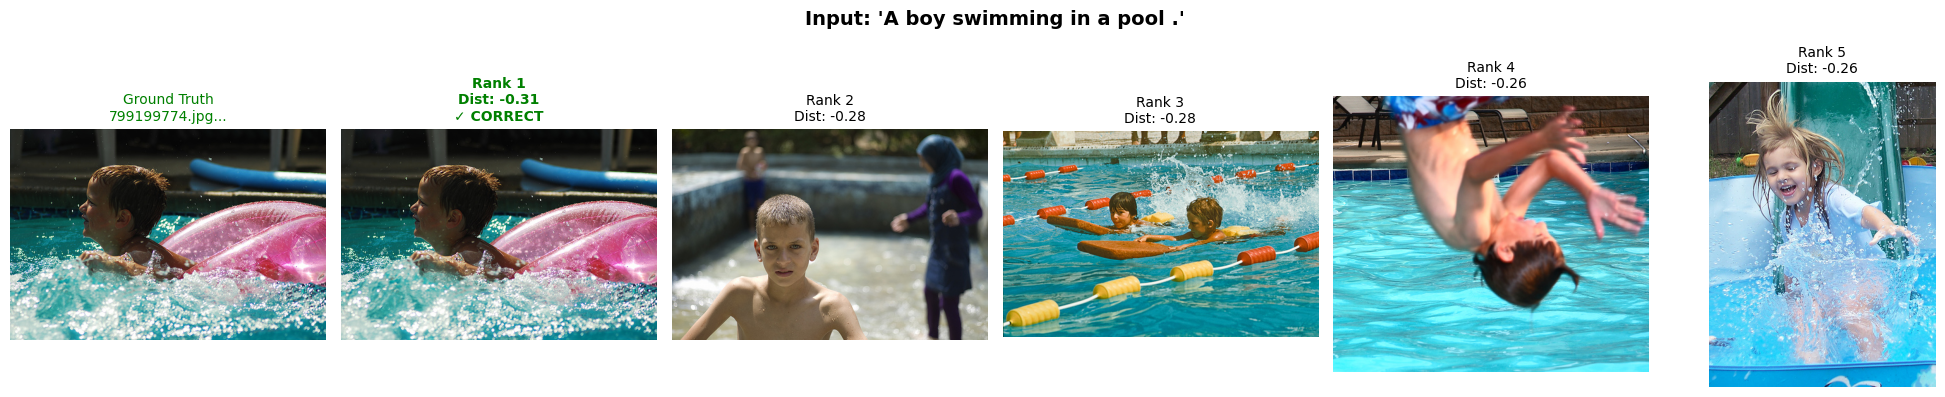

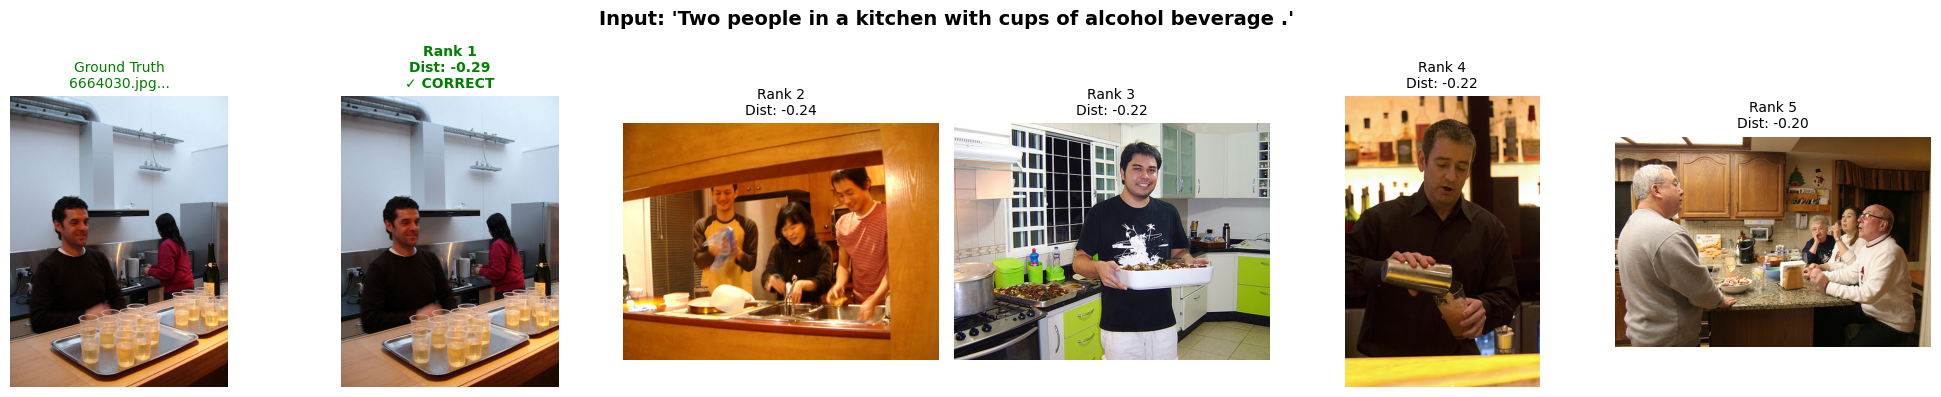

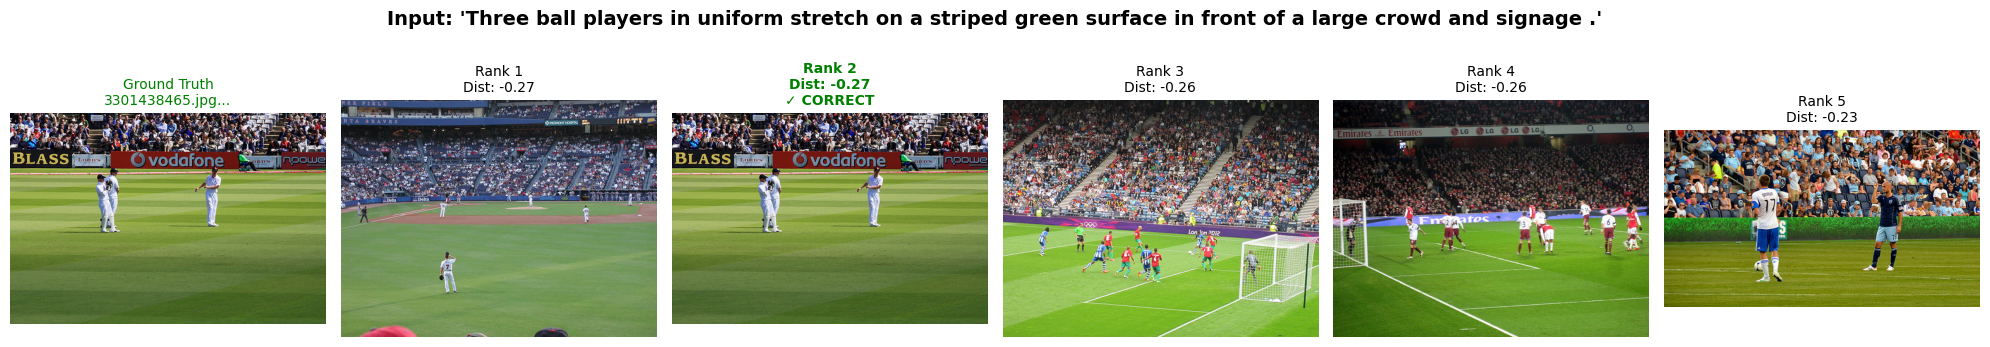


=== Val (image-level split, global gallery) ===
mrr            : 0.7750
ndcg           : 0.8249
recall_at_1    : 0.6808
recall_at_3    : 0.8462
recall_at_5    : 0.8954
recall_at_10   : 0.9407
recall_at_50   : 0.9841
l2_dist        : 1.1616


In [2]:

# ===========================
# Carica best e imposta eval
# ===========================
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from challenge.src.eval.metrics import mrr, ndcg, recall_at_k  # funzioni intoccabili

state = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# ============================================================
# 9) Aggregazione slot -> 1 embedding (submission compatibile)
# ============================================================
@torch.no_grad()
def aggregate_slots(S_T: torch.Tensor, V_ref: torch.Tensor | None = None, mode: str = "mean"):
    """
    S_T:   (B, K, D)  slots già L2-normalizzati
    V_ref: (B, D)     opzionale, solo per mode="winner" (deve essere batch-aligned!)
    Ritorna: (B, D) L2-normalizzato
    """
    assert S_T.dim() == 3, f"aggregate_slots: atteso (B,K,D), trovato {tuple(S_T.shape)}"
    if mode == "mean" or V_ref is None:
        out = S_T.mean(dim=1)                  # (B, D)
        return F.normalize(out, dim=-1)

    # winner-slot richiede un riferimento allineato per ogni sample
    assert V_ref is not None, "mode='winner' richiede V_ref"
    assert V_ref.dim() == 2 and V_ref.size(0) == S_T.size(0), \
        f"V_ref shape mismatch: atteso (B,D) con B={S_T.size(0)}, trovato {tuple(V_ref.shape)}"

    Vn = F.normalize(V_ref, dim=-1)            # (B, D)
    sims = torch.einsum('bkd,bd->bk', S_T, Vn) # (B, K)
    idx  = sims.argmax(dim=1)                  # (B,)
    out  = S_T[torch.arange(S_T.size(0), device=S_T.device), idx, :]  # (B, D)
    return F.normalize(out, dim=-1)

# ===========================
# Split COERENTE per IMMAGINI
# ===========================
import hashlib
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# 1) Identificatori immagine (array di nomi file, lunghezza N_img)
img_names_all = train_data['images/names']                  # (N_img,)
img_emb_all   = torch.from_numpy(train_data['images/embeddings'])  # (N_img, D_img)

# 2) Split deterministico per immagini (es. 90/10) con hash -> evita leakage caption-level
val_ratio = 0.10
def stable_hash(name: str) -> float:
    h = hashlib.md5(name.encode('utf-8')).hexdigest()
    return int(h[:8], 16) / 0xFFFFFFFF

img_hash = np.array([stable_hash(nm) for nm in img_names_all])
IMG_VAL_MASK  = img_hash < val_ratio
IMG_TRAIN_MASK = ~IMG_VAL_MASK

# Versione robusta (gestisce anche sparse matrix)
from scipy import sparse

cap_to_img = train_data['captions/label']
if sparse.issparse(cap_to_img):
    cap_gt_img_idx = cap_to_img.argmax(axis=1).A1
else:
    # Evita la conversione a bool per risparmiare memoria
    cap_gt_img_idx = np.argmax(cap_to_img, axis=1)


CAP_TRAIN_MASK = IMG_TRAIN_MASK[cap_gt_img_idx]
CAP_VAL_MASK   = IMG_VAL_MASK[cap_gt_img_idx]

# 4) Tensors train/val (caption→embedding, image target embedding)
X_train = X[CAP_TRAIN_MASK]
y_train = y[CAP_TRAIN_MASK]
X_val   = X[CAP_VAL_MASK]
y_val   = y[CAP_VAL_MASK]

train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Train captions: {len(X_train):,} | Val captions: {len(X_val):,}")
print(f"Train images  : {IMG_TRAIN_MASK.sum():,} | Val images  : {IMG_VAL_MASK.sum():,}")

# 5) Gallery di VALIDAZIONE: SOLO immagini di val, de-duplicate e normalizzate
val_img_file  = img_names_all[IMG_VAL_MASK]
val_img_embd  = F.normalize(img_emb_all[torch.from_numpy(IMG_VAL_MASK)], dim=-1).cpu()  # (N_img_val, D)

# 6) Ground-truth per caption di val: indice nella gallery di val
#    Dato cap_gt_img_idx (indice globale), rimappiamo agli indici compatti della gallery val
global_to_val = -np.ones(len(img_names_all), dtype=np.int64)
global_to_val[np.where(IMG_VAL_MASK)[0]] = np.arange(IMG_VAL_MASK.sum(), dtype=np.int64)

val_gt_global = cap_gt_img_idx[CAP_VAL_MASK]     # (Nq,)
val_label = global_to_val[val_gt_global]         # (Nq,), ciascuno in [0, N_img_val)

# =============================
# Visualizza qualche retrieval
# =============================
for _ in range(3):
    idx = np.random.randint(0, len(X_val))
    caption_embd = X_val[idx:idx+1].to(DEVICE)
    caption_text = train_data['captions/text'][CAP_VAL_MASK][idx]
    gt_index     = int(val_label[idx])

    with torch.no_grad():
        S_T, _, _ = model(caption_embd)
        pred_embd = aggregate_slots(S_T, mode="mean").cpu().squeeze(0)
        visualize_retrieval(pred_embd, gt_index, val_img_file, caption_text, val_img_embd, k=5)

# ============================================================
# Valutazione COERENTE su gallery completa di VALIDAZIONE
# ============================================================
@torch.no_grad()
def evaluate_retrieval_global(Z: torch.Tensor,
                              gallery: torch.Tensor,
                              gt_indices: np.ndarray,
                              topk: int = 100,
                              chunk: int = 512):
    from challenge.src.eval.metrics import mrr, ndcg, recall_at_k  # intoccabili
    Z = Z.to('cpu')
    gallery = gallery.to('cpu')
    Nq, Ng = Z.size(0), gallery.size(0)
    topk = min(topk, Ng)

    all_topk = []
    for start in range(0, Nq, chunk):
        end = min(start + chunk, Nq)
        sims = Z[start:end] @ gallery.T
        topk_idx = torch.topk(sims, k=topk, dim=1, largest=True, sorted=True).indices
        all_topk.append(topk_idx.cpu().numpy())
    pred_indices = np.vstack(all_topk).astype(np.int64)

    l2_dist = (Z - gallery[torch.from_numpy(gt_indices)]).norm(dim=1).mean().item()
    return {
        'mrr': mrr(pred_indices, gt_indices),
        'ndcg': ndcg(pred_indices, gt_indices),
        'recall_at_1':  recall_at_k(pred_indices, gt_indices, 1),
        'recall_at_3':  recall_at_k(pred_indices, gt_indices, 3),
        'recall_at_5':  recall_at_k(pred_indices, gt_indices, 5),
        'recall_at_10': recall_at_k(pred_indices, gt_indices, 10),
        'recall_at_50': recall_at_k(pred_indices, gt_indices, 50),
        'l2_dist': l2_dist,
    }

# ---- Embedding caption di validazione + valutazione ----
with torch.no_grad():
    preds_val = []
    for Xb, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        Xb = Xb.to(DEVICE)
        S_Tb, _, _ = model(Xb)
        Eb = aggregate_slots(S_Tb, mode="mean")
        preds_val.append(Eb.cpu())
Z_val = F.normalize(torch.cat(preds_val, dim=0), dim=-1).cpu()

res_val = evaluate_retrieval_global(Z_val, val_img_embd, val_label, topk=100, chunk=512)
print("\n=== Val (image-level split, global gallery) ===")
for k, v in res_val.items():
    print(f"{k:15s}: {v:.4f}")




    === Val (image-level split, global gallery) ===
    mrr            : 0.8240
    ndcg           : 0.8629
    recall_at_1    : 0.7479
    recall_at_3    : 0.8841
    recall_at_5    : 0.9231
    recall_at_10   : 0.9555
    recall_at_50   : 0.9851
    l2_dist        : 1.1590

In [5]:
# ============================================================
# Valuta tutti i checkpoint sul validation set (MRR globale)
# ============================================================
from pathlib import Path
from challenge.src.eval.metrics import mrr

ckpt_dir = Path(MODEL_PATH).parent / "checkpoints"
checkpoints = sorted(ckpt_dir.glob("epoch_*.pth"))

results = []
with torch.no_grad():
    for ckpt_path in checkpoints:
        state = torch.load(ckpt_path, map_location=DEVICE)
        model.load_state_dict(state)
        model.eval()

        preds_val = []
        for Xb, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
            Xb = Xb.to(DEVICE)
            S_Tb, _, _ = model(Xb)
            Eb = aggregate_slots(S_Tb, mode="mean")
            preds_val.append(Eb.cpu())
        Z_val = F.normalize(torch.cat(preds_val, dim=0), dim=-1).cpu()

        # cosine similarity → pred indices
        sims = Z_val @ val_img_embd.T
        topk_idx = torch.topk(sims, k=100, dim=1, largest=True, sorted=True).indices.numpy()
        mrr_val = mrr(topk_idx, val_label)

        results.append((ckpt_path.name, mrr_val))
        print(f"{ckpt_path.name:15s} → MRR={mrr_val:.5f}")

# ordina e mostra il migliore
best_ckpt, best_mrr = max(results, key=lambda x: x[1])
print("\n=== Miglior checkpoint ===")
print(f"{best_ckpt} → MRR={best_mrr:.5f}")


epoch_001.pth   → MRR=0.53412
epoch_002.pth   → MRR=0.61269
epoch_003.pth   → MRR=0.65504
epoch_004.pth   → MRR=0.69439
epoch_005.pth   → MRR=0.74003
epoch_006.pth   → MRR=0.76252
epoch_007.pth   → MRR=0.77496
epoch_008.pth   → MRR=0.78528
epoch_009.pth   → MRR=0.79453
epoch_010.pth   → MRR=0.80791
epoch_011.pth   → MRR=0.81302
epoch_012.pth   → MRR=0.81612
epoch_013.pth   → MRR=0.82161
epoch_014.pth   → MRR=0.82619
epoch_015.pth   → MRR=0.82759
epoch_016.pth   → MRR=0.82865
epoch_017.pth   → MRR=0.82857
epoch_018.pth   → MRR=0.82960
epoch_019.pth   → MRR=0.82972
epoch_020.pth   → MRR=0.83007

=== Miglior checkpoint ===
epoch_020.pth → MRR=0.83007


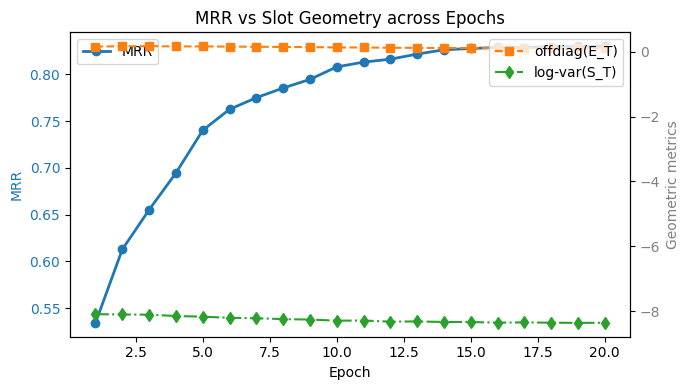


Correlazioni: MRR–offdiag = -0.792,  MRR–logvar = -0.924


In [6]:
# ============================================================
# Analisi avanzata: MRR vs geometria latente (offdiag, varianza)
# ============================================================
import matplotlib.pyplot as plt

geo_results = []

@torch.no_grad()
def diagnostics(E_T: torch.Tensor, S_T: torch.Tensor):
    # media off-diag e log-varianza già definite in training, replicate qui
    K = E_T.size(1)
    C = torch.matmul(E_T, E_T.transpose(-1, -2))
    offdiag = (C - torch.eye(K, device=E_T.device).unsqueeze(0)).abs().sum(dim=(1,2)) / (K*(K-1))
    var_fd = S_T.var(dim=1, unbiased=False).mean(dim=1)
    logvar = torch.log(var_fd.clamp_min(1e-8))
    return offdiag.mean().item(), logvar.mean().item()

with torch.no_grad():
    for ckpt_path, mrr_val in results:
        state = torch.load(ckpt_dir / ckpt_path, map_location=DEVICE)
        model.load_state_dict(state)
        model.eval()

        # calcola metriche geometriche su un sottoinsieme per efficienza
        Xb, Yb = next(iter(DataLoader(val_dataset, batch_size=256, shuffle=True)))
        Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
        S_Tb, E_Tb, _ = model(Xb)
        E_Tn = F.normalize(E_Tb, dim=-1)
        offdiag_mean, logvar_mean = diagnostics(E_Tn, S_Tb)

        geo_results.append({
            "epoch": int(ckpt_path.replace("epoch_", "").replace(".pth", "")),
            "mrr": mrr_val,
            "offdiag": offdiag_mean,
            "logvar": logvar_mean
        })

geo_results = sorted(geo_results, key=lambda x: x["epoch"])

# --- grafico ---
epochs = [r["epoch"] for r in geo_results]
mrr_vals = [r["mrr"] for r in geo_results]
off_vals = [r["offdiag"] for r in geo_results]
var_vals = [r["logvar"] for r in geo_results]

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(epochs, mrr_vals, 'o-', label="MRR", linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MRR", color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(epochs, off_vals, 's--', color='C1', label="offdiag(E_T)")
ax2.plot(epochs, var_vals, 'd-.', color='C2', label="log-var(S_T)")
ax2.set_ylabel("Geometric metrics", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("MRR vs Slot Geometry across Epochs")
plt.tight_layout()
plt.show()

# --- correlazioni numeriche ---
import numpy as np
off_corr = np.corrcoef([r["mrr"] for r in geo_results],
                       [r["offdiag"] for r in geo_results])[0,1]
var_corr = np.corrcoef([r["mrr"] for r in geo_results],
                       [r["logvar"] for r in geo_results])[0,1]
print(f"\nCorrelazioni: MRR–offdiag = {off_corr:+.3f},  MRR–logvar = {var_corr:+.3f}")


In [ ]:
# ============================================================
# 10) Submission (robusta e consistente con la validazione)
# ============================================================
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader

test_data  = load_data("data/test/test.clean.npz")
test_ids   = test_data['captions/ids']
test_embds = torch.from_numpy(test_data['captions/embeddings']).float()  # (N, D_txt)

pred_chunks = []
with torch.inference_mode():
    model.eval()
    # Nota: niente shuffle; batch size come in validazione/inferenza
    for Xb in DataLoader(test_embds, batch_size=BATCH_SIZE, shuffle=False):
        Xb = Xb.to(DEVICE, non_blocking=False)
        S_Tb, _, _ = model(Xb)                     # (B, K, D)
        Eb = aggregate_slots(S_Tb, mode="mean")    # (B, D), già L2-normalizzato
        Eb = F.normalize(Eb, dim=-1)               # idempotente: garantisce norma unitaria
        pred_chunks.append(Eb.cpu().to(torch.float32))

pred_embds_test = torch.cat(pred_chunks, dim=0)   # (N, D) CPU float32

# Sanity checks
assert pred_embds_test.ndim == 2, f"Got shape {tuple(pred_embds_test.shape)}"
assert len(test_ids) == pred_embds_test.size(0), \
    f"ids({len(test_ids)}) != preds({pred_embds_test.size(0)})"
# Evita NaN/Inf accidentali
if not torch.isfinite(pred_embds_test).all():
    pred_embds_test = torch.nan_to_num(pred_embds_test, nan=0.0, posinf=1.0, neginf=-1.0)
    pred_embds_test = F.normalize(pred_embds_test, dim=-1)

# (Opzionale) Salvataggio per analisi locale
np.save("pred_test_embeddings.npy", pred_embds_test.numpy())

# Genera CSV (la funzione accetta anche torch.Tensor)
submission = generate_submission(test_ids, pred_embds_test, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")
print("Submission saved to: submission.csv")


Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/maxmatch_adapter_k6_sinkhorn.pth
Submission saved to: submission.csv
